In [15]:
import pandas as pd
import numpy as np
from sklearn import cross_validation, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.grid_search import GridSearchCV

In [5]:
from data_pipeline.data_clean import read_file

In [5]:
filename = 'data_collection/match_history_sample.json'

In [7]:
# match_json_array = []
with open(filename) as f:
#     print sum(1 for _ in f)
   arr = [next(f) for x in xrange(300)]
#     for linze in f:
#         match_json_array.append(line)

In [8]:
t = map(lambda x: pd.read_json(x), arr)


In [9]:
df = pd.concat(t,ignore_index=True)

In [10]:
df = pd.DataFrame(df.matches.tolist())

In [11]:
df_10player = df[df['human_players']==10]

In [12]:
def match_features(players):
    vec = np.zeros(224, dtype=np.int)
    loc = np.append(np.zeros(5, dtype=np.int), np.ones(5, dtype=np.int)*112)
    loc+=map(lambda x: x['hero_id']-1, players)
    vec[loc]=1
    return vec

def matches_features(df):
    df_feature = df['players'].apply(lambda x: match_features(x))
    X = pd.DataFrame(df_feature.tolist())
    y = df['radiant_win']
    return X, y

In [13]:
X, y = matches_features(df_10player)

# Random Forest

In [120]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.8)

In [21]:
# Set the parameters by cross validation

tuned_parameters = [
                    {'n_estimators':[100, 1000, 10000]},
                    {'max_features':[5, 'auto', None]},
                    {'min_samples_leaf':[1, 50, 150]}
                    ]

In [16]:
clf_rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=50)

In [17]:
clf = GridSearchCV(clf_rf, tuned_parameters, cv=5)

In [18]:
clf.fit(X_train, y_train)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=True, random_state=50, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [100, 1000, 10000]}, {'max_features': [5, 'auto', None]}, {'min_samples_leaf': [1, 50, 150]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [19]:
clf.best_params_                                            

{'n_estimators': 10000}

#### Random Forest

In [29]:
clf_rf =RandomForestClassifier(n_estimators=10000,n_jobs=-1, min_samples_leaf=50, random_state=50)

In [13]:
cross_validation.cross_val_score(clf_rf, X, y, cv=5)

array([ 0.57797831,  0.59903382,  0.5783429 ,  0.58350046,  0.58395624])

#### Logistics

In [31]:
clf_log_r = linear_model.LogisticRegression()
# cross_validation.cross_val_score(clf_log_r, X, y, cv=5)

In [117]:
# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
# clf = GridSearchCV(linear_model.LogisticRegression(penalty='l2'), param_grid)
clf=GridSearchCV(cv=None,
                 estimator=linear_model.LogisticRegression(C=1.0, 
                                              intercept_scaling=1, 
                                              dual=False, 
                                              fit_intercept=True, 
                                              penalty='l2', 
                                              tol=0.0001),
                 param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [118]:
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [119]:
clf.best_params_

{'C': 1}

In [15]:
clf_log_r

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
# Learn to predict each class against the other

# classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
#                                  random_state=random_state))
y_score = clf_log_r.fit(X_train, y_train).decision_function(X_test)

In [33]:
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

In [35]:
y_rf_score = clf_rf.predict_proba(X_test)

In [36]:
y_rf_score

array([[ 0.4811879 ,  0.5188121 ],
       [ 0.51872705,  0.48127295],
       [ 0.54402634,  0.45597366],
       ..., 
       [ 0.55223002,  0.44776998],
       [ 0.44723144,  0.55276856],
       [ 0.58144767,  0.41855233]])

In [37]:
clf_ab = AdaBoostClassifier()

In [38]:
clf_ab.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [39]:
y_ab_score = clf_ab.predict_proba(X_test)

In [40]:
y_ab_score

array([[ 0.50005634,  0.49994366],
       [ 0.50000864,  0.49999136],
       [ 0.50317585,  0.49682415],
       ..., 
       [ 0.5023671 ,  0.4976329 ],
       [ 0.49769013,  0.50230987],
       [ 0.50286483,  0.49713517]])

In [41]:
roc_auc_score(y_test, y_ab_score[:,1])

0.60457524869544554

In [18]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

%matplotlib inline

In [42]:
roc_auc_score(y_test, y_score)

0.62541703180847819

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

In [61]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_rf_score[:,1])
fpr_ab, tpr_ab, _ = roc_curve(y_test, y_ab_score[:,1])

In [44]:
auc(fpr, tpr)

0.62541703180847819

In [72]:
import matplotlib

In [44]:
matplotlib.use('Agg')

In [45]:
roc_auc_score(y_test, y_rf_score[:,1])

0.61362057854411012

In [51]:
from ggplot import *

In [69]:
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
# ggplot(df, aes(x='fpr', y='tpr')) +\
#     geom_line() +\
#     geom_abline(linetype='dashed')
    
df_rf = pd.DataFrame(dict(fpr=fpr_rf, tpr=tpr_rf))
# ggplot(df_rf, aes(x='fpr', y='tpr')) +\
#     geom_line() +\
#     geom_abline(linetype='dashed')
    
df_ab = pd.DataFrame(dict(fpr=fpr_ab, tpr=tpr_ab))
    
ggplot(aes(x='fpr', y='tpr'), data=df) + geom_line() +\
       geom_point(aes(x='fpr', y='tpr'), data=df_rf) + geom_line() +\
            geom_point(aes(x='fpr', y='tpr'), data=df_ab) + geom_line() +\
                geom_abline(linetype='dashed')

TypeError: __init__() got an unexpected keyword argument 'color'

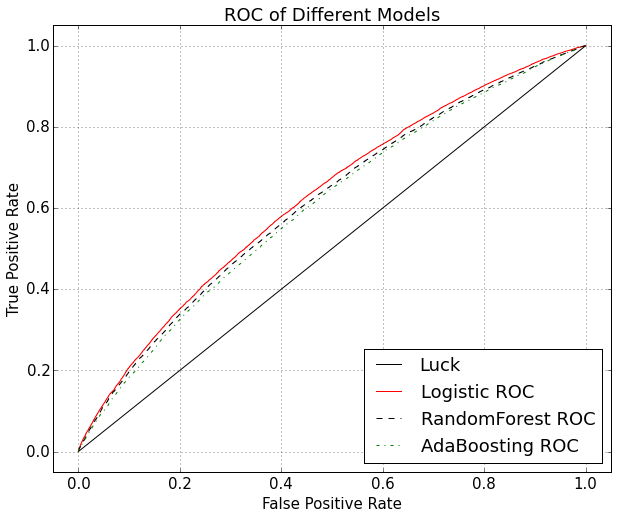

In [84]:
# plt.figure(num=None, figsize=(12, 9), dpi=800, facecolor='w', edgecolor='k')

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], '-', color=(.01, .01, .01), label='Luck')

plt.plot(fpr, tpr, '-', c='r',
         label='Logistic ROC', lw=1)

plt.plot(roc_curve(y_test, y_rf_score[:,1])[0], roc_curve(y_test, y_rf_score[:,1])[1], 'k--',
        label ='RandomForest ROC', lw=1)

plt.plot(roc_curve(y_test, y_ab_score[:,1])[0], roc_curve(y_test, y_ab_score[:,1])[1], '-.',
        label ='AdaBoosting ROC', lw=1)

matplotlib.rcParams.update({'font.size': 15})
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Different Models')
plt.legend(loc="lower right")
plt.grid(True)


plt.savefig('file/roc_curve_model')

In [1]:
pwd

u'/home/hao/Repos/DSI/DOTA2_Recommendation-System/notebook'

In [2]:
cd ..

/home/hao/Repos/DSI/DOTA2_Recommendation-System


In [3]:
ls

data_collection/  data_pipeline/  file/  model/  notebook/  README.md  Test/


In [10]:
from model.dota_model import Dota2_model

In [11]:
model = Dota2_model()

In [12]:
a, b, c = model.model_training()

In [14]:
len(b)

3

In [20]:
c

[0.62278845288711271, 0.60843451845920393, 0.60416419319944936]

In [24]:
a

[LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr',
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_samples_leaf=50, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
             oob_score=False, random_state=50, verbose=0, warm_start=False),
 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
           learning_rate=1.0, n_estimators=50, random_state=None)]

In [28]:
a[0].predict_proba(X_test)

array([[ 0.65563208,  0.34436792],
       [ 0.54136025,  0.45863975],
       [ 0.65216487,  0.34783513],
       ..., 
       [ 0.53261411,  0.46738589],
       [ 0.47437883,  0.52562117],
       [ 0.79630093,  0.20369907]])

In [27]:
a[0].predict_proba(X_test)[:,1]

array([ 0.34436792,  0.45863975,  0.34783513, ...,  0.46738589,
        0.52562117,  0.20369907])

In [16]:
X_train, X_test, y_train, y_test = model.train_test_split()

In [22]:
roc_curve(y_test, y_scores[0])

(array([  0.00000000e+00,   4.75986482e-05,   9.51972964e-05, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00]),
 array([ 0.        ,  0.        ,  0.        , ...,  0.99991256,
         0.99995628,  1.        ]),
 array([ 1.93226374,  0.93226374,  0.91163622, ...,  0.09284588,
         0.09279502,  0.07263732]))

In [23]:
y_scores[0]

array([ 0.71936778,  0.33377561,  0.54321757, ...,  0.71605168,
        0.60081588,  0.45159316])

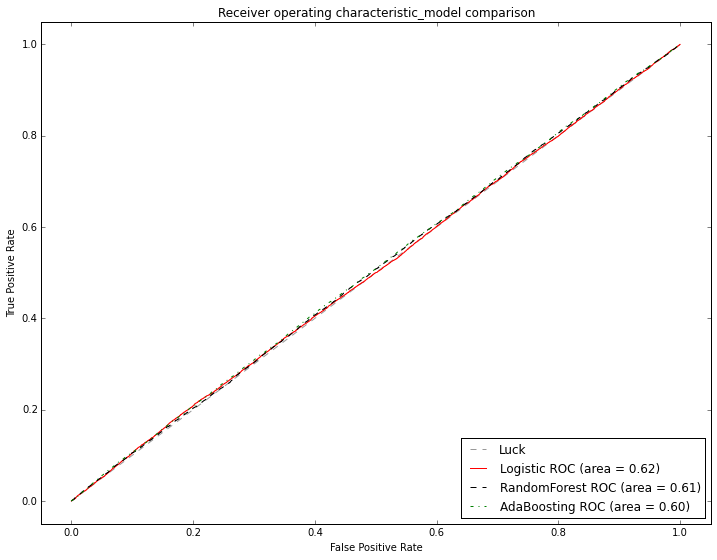

In [21]:
y_scores=b
auc_score=c
plt.figure(num=None, figsize=(12, 9), dpi=800,
                   facecolor='w', edgecolor='k')
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test, y_scores[i])
    if i == 0:
        plt.plot(fpr, tpr,
                 '-', c='r', lw=1,
                 label='Logistic ROC (area = %0.2f)'
                 % auc_score[i])
    if i == 1:
        plt.plot(fpr, tpr,
                 'k--', lw=1,
                 label='RandomForest ROC (area = %0.2f)'
                 % auc_score[i])
    if i == 2:
        plt.plot(fpr, tpr,
                 '-.', lw=1,
                 label='AdaBoosting ROC (area = %0.2f)'
                 % auc_score[i])

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic_model comparison')
plt.legend(loc="lower right")

In [113]:
import pickle

In [114]:
with open('file/model.pkl') as f:
    clf_pkl = pickle.load(f)

In [108]:
print clf_pkl == clf_log_r

False


In [109]:
clf_pkl

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [110]:
y_pkl_score = clf_pkl.predict_log_proba(X_test)

In [112]:
roc_auc_score(y_test, y_pkl_score[:, 1])

0.63349474624467683

In [121]:
clf_pkl

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [119]:
X, y = model.csv_transform()

In [8]:
X = np.array(X)

In [9]:
X.shape

(54853, 220)

In [10]:
y[:5]

[True, True, True, True, False]

In [ ]:
model.

In [4]:
df = pd.read_csv('file/heroes_csv', index_col=[0])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219416 entries, 1 to 259999
Data columns (total 12 columns):
0              219416 non-null int64
1              219416 non-null int64
2              219416 non-null int64
3              219416 non-null int64
4              219416 non-null int64
5              219416 non-null int64
6              219416 non-null int64
7              219416 non-null int64
8              219416 non-null int64
9              219416 non-null int64
radiant_win    219416 non-null bool
match_id       219416 non-null int64
dtypes: bool(1), int64(11)
memory usage: 20.3 MB


In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,radiant_win,match_id
1,19,74,18,84,75,93,63,21,8,7,True,1936712411
2,57,99,11,8,76,21,44,28,5,59,True,1936756135
3,14,25,59,109,22,8,64,28,86,70,False,1936757580
4,74,106,112,53,4,39,70,92,8,67,False,1936768967
6,94,36,112,88,67,25,48,59,21,104,True,1936747708


In [76]:
with open ('file/heroes_csv') as f:
    a = [next(f) for i in range(5)]

In [77]:
a

[',0,1,2,3,4,5,6,7,8,9,radiant_win,match_id\n',
 '1,19,74,18,84,75,93,63,21,8,7,True,1936712411\n',
 '2,57,99,11,8,76,21,44,28,5,59,True,1936756135\n',
 '3,14,25,59,109,22,8,64,28,86,70,False,1936757580\n',
 '4,74,106,112,53,4,39,70,92,8,67,False,1936768967\n']

In [80]:
a[3].split(",")

['3',
 '14',
 '25',
 '59',
 '109',
 '22',
 '8',
 '64',
 '28',
 '86',
 '70',
 'False',
 '1936757580\n']